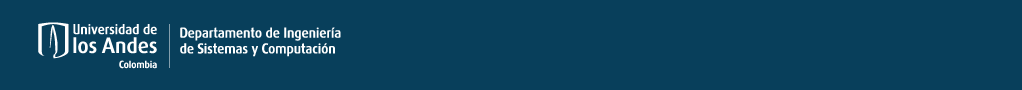

In [1]:
!rm -rf ./data

# Ciencia de datos aplicada
-------------------------------

# Grupo 05 - Entrega 3

## Integrantes:

1. Geovanny Andrés González - 201719528
2. Andrés Felipe Vega Chacón - 201910197
3. Wilson Camilo Sánchez - 201820379

# MODELO DE PREDICCIÓN DE ENFERMEDAD CARDIACA

## Descripción del problema

Según datos de la Organización Mundial de la Salud, las enfermedades cardiovasculares para el año 2015 fueron la principal causa de muerte; alcanzando 17,7 millones de personas fallecidas con síntomas asociados a hipertensión arterial, obesidad y tabaquismo que posteriormente desencadenan las enfermedades cardiacas.
Por lo tanto, en muchos de los casos las enfermedades cardiacas se pueden prevenir con diagnósticos a tiempo de enfermedades asociadas para disminuir el riesgo de deceso o complicaciones médicas.

## Objetivos

- identificar cuales son los factores con mayor incidencia en el padecimiento de la enfermedad cardiaca

- Aplicar modelos de machine learnig que permita determinar si un paciente tiene alto o bajo riesgo de presentar enfermedad cardiaca

## Preparación del entorno

A continuación, vamos a descargar las librerias necesarias para la ejecución del ejercicio. De igual modo, vamos a descargar el dataset de trabajo.

**Nota:** recomendamos ejecutar este notebook desde **Google Colab** debido a que vamos a trabajar con diversas librerias complicadas de instalar como Tensorflow y Tensorboard. 

### Descarga de librerias

In [2]:
%%capture
!pip install -U scikit-learn
!pip install plotly
!pip install pandas-profiling==3.1.0
!pip install xgboost==1.5.0
!pip install tensorflow-addons

### Descargar datos

Puede acceder a la URL original del *dataset* haciendo clic en el siguiente enlace. Debido a que vamos a trabajar con **Google Colab**, Kaggle no permite descargar el dataset directamente, por lo que lo vamos a replicar en un bucket de **Amazon S3**

**Dataset en Kaggle**: [Dataset](https://www.kaggle.com/nareshbhat/health-care-data-set-on-heart-attack-possibility)

In [3]:
# Crear la carpeta con los datos
DATA_PATH = "/content/data"
!mkdir -p $DATA_PATH

In [4]:
# Descargar los datos
DATA_URL = "https://ggonzr-public-data.s3.amazonaws.com/cda/heart.csv"
!wget --directory-prefix $DATA_PATH/ $DATA_URL

--2021-11-15 23:42:05--  https://ggonzr-public-data.s3.amazonaws.com/cda/heart.csv
Resolving ggonzr-public-data.s3.amazonaws.com (ggonzr-public-data.s3.amazonaws.com)... 52.216.169.131
Connecting to ggonzr-public-data.s3.amazonaws.com (ggonzr-public-data.s3.amazonaws.com)|52.216.169.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/csv]
Saving to: ‘/content/data/heart.csv’

heart.csv           100%[===================>]  11.06K  --.-KB/s    in 0s      

2021-11-15 23:42:05 (118 MB/s) - ‘/content/data/heart.csv’ saved [11328/11328]



### Importar librerías

In [5]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas_profiling as pp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import os

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, confusion_matrix
from typing import List
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score, roc_auc_score
import sklearn.metrics as metrics

%matplotlib inline

In [6]:
# Validar que Tensorflow esté disponible en el entorno
try:
  %tensorflow_version 2.x
except:
  print("Por favor ejecute el notebook en Google Colab")

### Cargar datos

A continuación, vamos a realizar la carga inicial de los datos

In [7]:
df = pd.read_csv(filepath_or_buffer=f"{DATA_PATH}/heart.csv")
df.head(4)

age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1

[4 rows x 14 columns]

In [8]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

## Enfoque analítico

En Cleveland han recolectado información relacionada con variables asociadas a los problemas cardiacos para caracterizar a los pacientes. Con esta información se desea implementar modelos de machine learning para obtener una recomendación de la probabilidad que puede tener un paciente de padecer una enfermedad cardiaca y así mismo mejorar el dictamen de los profesionales de la salud.

Contamos con un data set de 303 registros y 14 campos detallados a continuación:

- Edad
- Sexo
- Tipo de dolor en el pecho (4 valores)
- Presión arterial en reposo
- Colesterol sérica en mg / dl
- Azúcar en sangre en ayunas> 120 mg / dl
- Resultados electrocardiográficos en reposo (valores 0,1,2)
- Frecuencia cardíaca máxima alcanzada
- Angina inducida por el ejercicio
- oldpeak = depresión del ST inducida por el ejercicio en relación con el reposo
- La pendiente del segmento ST de ejercicio pico
- Número de vasos principales (0-3) coloreados por la floración
- thal: 0 = normal; 1 = defecto fijo; 2 = defecto reversible
- target: 0 = menos probabilidad de ataque cardíaco 1 = más probabilidad de ataque cardíaco

Cada registro corresponde con la histórica clínica de un paciente. En este data set encontramos información de pacientes con características normales y pacientes con problemas cardiacos, por lo cual es un insumo importante para entrenar modelos de machine learnig para realizar la clasificación de ser propenso o no de padecer enfermedad cardiaca.


## Entendimiento y preparación de los datos

Análisis exploratorio sobre la calidad del conjunto de datos:

In [9]:
pd_prof = pp.ProfileReport(df, title="Información cardiovascular")

In [10]:
# Mostrar el reporte
pd_prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Podemos evidenciar que de las 14 variables 5 son numéricas y 9 son categóricas. Los datos estan completos y solo presentamos duplicidad en 1 registro. Por lo cual posteriormente vamos a realizar la limpieza de duplicados y transformar las variables categóricas como One-hot-encoding, esto último se puede observar en la sección **Generación de variables dummies a partir de los datos categoricos**

In [11]:
print("Tamaño de los datos antes de la depuración: " + str(df.shape) + "\n")

df = df.dropna()
df = df.drop_duplicates()

print("Tamaño de los datos despues de la depuración: " + str(df.shape) + "\n")
print("Cambio de tipo de dato:\n" + str(df.dtypes))

Tamaño de los datos antes de la depuración: (303, 14)

Tamaño de los datos despues de la depuración: (302, 14)

Cambio de tipo de dato:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


## Preparación de los datos

En esta sección, vamos a separar el conjunto de datos en entrenamiento, validación y test

In [12]:
# Selección de las variables de entrenamiento
y_data = df["target"]
x_data = df.drop(columns="target")

# Separar el conjunto de test: 20%
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=5)

# Separar el conjunto de validación: 20%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=6)

#### Validación de la distribución

Para corroborar que la distribución de los datos sea similiar, vamos a realizar un histograma y en él vamos a graficar la distribución de los datos.

In [13]:
def graph_var(x_train: np.array, x_val: np.array, x_test: np.array, vars: List[str]):
  """
  Permite graficar la distribución de una variable
  para cada uno de los subconjuntos de datos

  x_train: np.array
    Subconjunto de entrenamiento
  x_val: np.array
    Subconjunto de validación
  x_test: np.array
    Subconjunto de pruebas
  vars: List[str]
    Variables a graficar. Deben pertenecer a los 3 subconjuntos  
  """

  # Crear la nueva figura
  fig, ax = plt.subplots(nrows=len(vars), ncols=3, figsize=(30, 100))

  # Graficar las 3 distribuciones
  for var_idx in range(len(vars)):
    var_name = vars[var_idx]
    sns.histplot(data=x_train, x=var_name, kde=True, ax=ax[var_idx, 0]).set(title=f"Distribución de {var_name} en x_train")
    sns.histplot(data=x_val, x=var_name, kde=True, ax=ax[var_idx, 1]).set(title=f"Distribución de {var_name} en x_val")
    sns.histplot(data=x_test, x=var_name, kde=True, ax=ax[var_idx, 2]).set(title=f"Distribución de {var_name} en x_test")

  return fig, ax

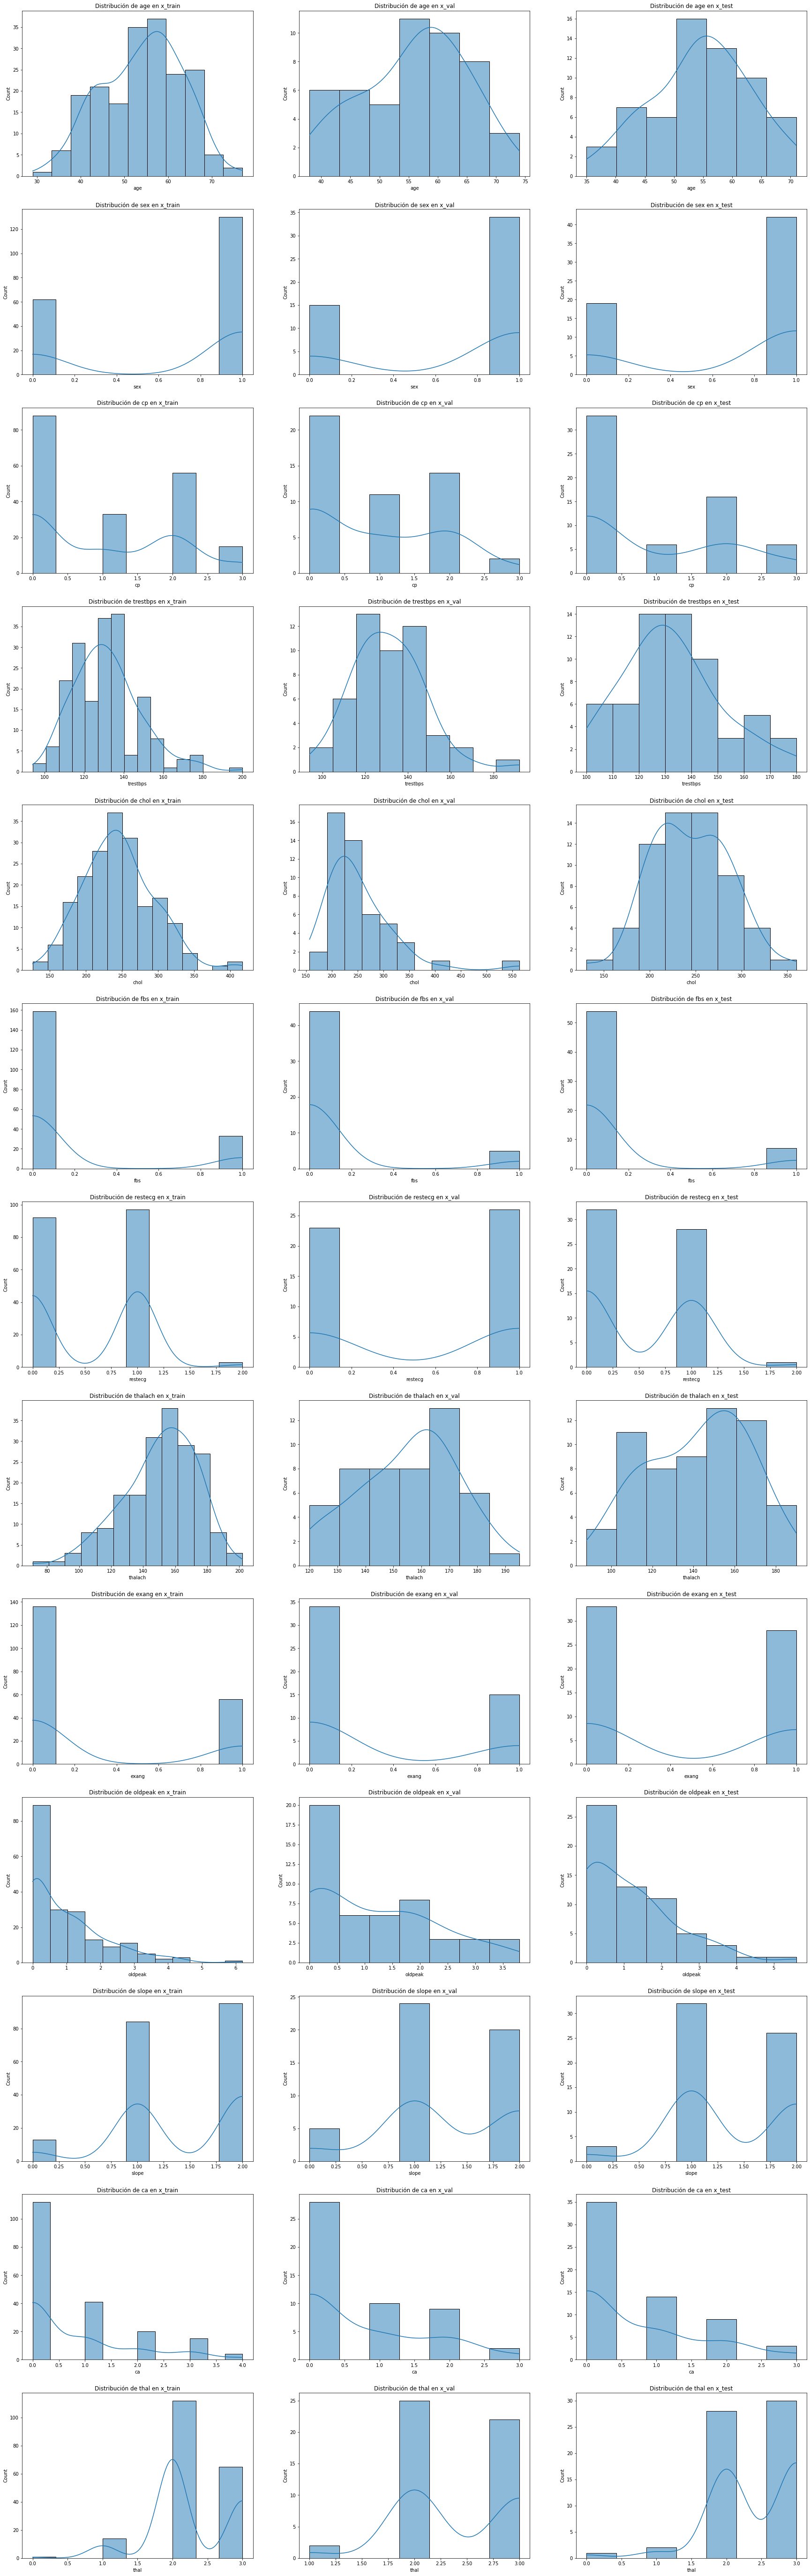

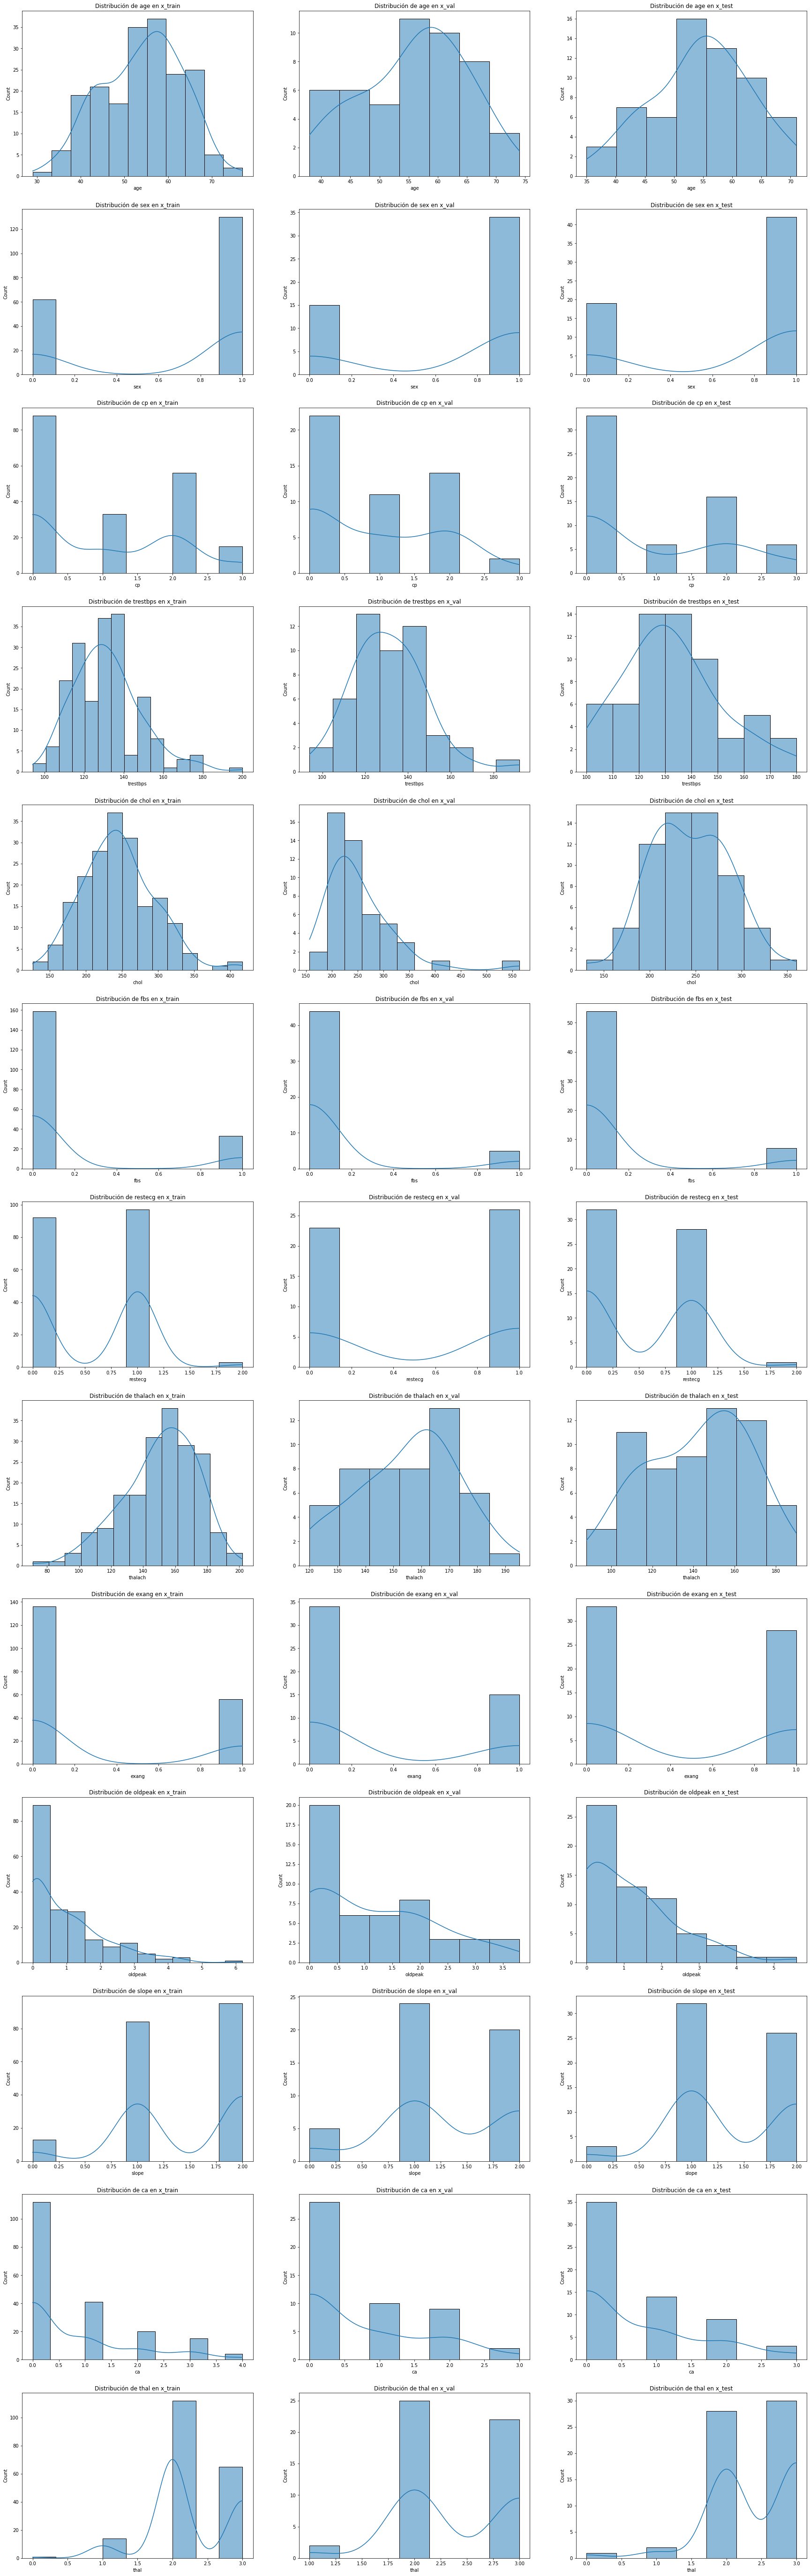

In [14]:
# Graficar la distribución de los conjuntos de datos
fig, ax = graph_var(x_train=x_train, x_val=x_val, x_test=x_test, vars=x_data.columns)
fig

Tras observar las distribuciones en los tres subconjuntos para cada una de las caracteristicas de los datos podemos concluir que las tres particiones mantienen la misma distribución. No obstante, existen algunas discrepancias que podemos observar en el conjunto de validación con respecto a las variables: thal, oldpeak y restecg. La dsitribución de estas tres variables parece diferir con respecto a los conjuntos de entrenamiento y test. Con respecto al conjunto de test, la única discrepancia observable reside en la distribución del colesterol (chol)

### Generación de variables dummies a partir de los datos categoricos

Las variables descritas a continuación son variables categoricas. Debido a ello, se transformaron siguiendo un patrón One Hot Encoding en el cuál cada valor del factor se transforma en una nueva caracteristica. Se seleccionó esta aproximación debido a que el número de variables categoricas no es muy grande.

In [15]:
df_cat = df
cat_list = ['sex','cp','fbs','restecg','exang','slope','ca','thal','target']
df_cat[cat_list] = df_cat[cat_list].astype('category')

# Selección de las variables de entrenamiento
y_dumm = df_cat["target"]
x_dumm = df_cat.drop(columns="target")

x_dumm = pd.get_dummies(x_dumm)

# Separar el conjunto de test: 20%
x_train, x_test, y_train, y_test = train_test_split(x_dumm, y_dumm, test_size=0.2, random_state=5)

# Separar el conjunto de validación: 20%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=6)

## Construcción del modelo

El modelo que vamos a emplear nos va ayudar a clasificar si una persona presenta un riesgo alto de sufir un ataque cardiaco o no. El objetivo de negocio de este modelo consiste en ayudar a priorizar automaticamente si un paciente requiere realizarse examenes exahustivos para ayudar a detectar oportunamente si posee riesgos de padecer un ataque cardiaco, lo anterior, bajo el marco de los programas de promoción y prevención.

Para ello, vamos a considerar los siguientes modelos de clasificación: 
1. Máquina de soporte vectorial (SVM)
2. XGBoost
3. Perceptrón multicapa (MLP)
4. Random Forest. 

Las métricas que vamos a emplear son exactitud, precisión, f-score y entropía cruzada. Para seleccionar el mejor modelo nos vamos a enfocar en el que mayor f-score posea y menor entropía cruzada.

A continuación, vamos a definir una función auxiliar que nos ayude a calcular rápidamente la métricas

In [16]:
def own_metrics(y_true: np.array, y_pred: np.array):
  cross_ent = log_loss(y_true=y_true, y_pred=y_pred)
  acc = accuracy_score(y_true=y_true, y_pred=y_pred)
  recall = recall_score(y_true=y_true, y_pred=y_pred)
  prec = precision_score(y_true=y_true, y_pred=y_pred)
  f1_s = f1_score(y_true=y_true, y_pred=y_pred)  

  print(f"""
    Entropía cruzada: {cross_ent:.2f}
    Exactitud: {acc:.2f}
    Precisión: {prec:.2f}
    Recall: {recall:.2f}
    F1 Score: {f1_s:.2f}    
  """)

### XGBoost

A continuación vamos a implementar el modelo utilizando el algoritmo: *Extreme Gradient Boosting (XGBoost)*

In [17]:
# Instanciar el clasificador
xgb_reg = xgb.XGBClassifier(    
    tree_method="hist",
    eval_metric="logloss",
)

In [18]:
# Entrenar el clasificador
xgb_reg.fit(X=x_train, y=y_train)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [19]:
# Calcular predicción: vamos a emplear el conjunto de validación
xgb_y_pred = xgb_reg.predict(x_val)

In [20]:
# Calcular métricas
own_metrics(y_true=y_val, y_pred=xgb_y_pred)


    Entropía cruzada: 7.75
    Exactitud: 0.78
    Precisión: 0.78
    Recall: 0.81
    F1 Score: 0.79    
  


### Perceptrón multicapa (MLP)

Para la definición del modelo de perceptrón multicapa vamos a emplear la libreria de alto nivel Keras soportada por el motor de Tensorflow

In [21]:
# Definición del modelo
mlp_model = keras.models.Sequential([
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1, activation="sigmoid")
])

In [22]:
# Compilación y entrenamiento del modelo
mlp_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[      
      keras.metrics.Precision(),
      keras.metrics.Recall(),
    ]
)

mlp_model.fit(
    x=x_train,
    y=y_train,
    epochs=10,    
)

Epoch 1/10
6/6 [==============================] - 1s 5ms/step - loss: 8.9127 - precision: 0.5968 - recall: 0.3333     
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 6.0745 - precision: 0.5767 - recall: 0.9820
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 3.0453 - precision: 0.5610 - recall: 0.2072
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 1.8318 - precision: 0.5857 - recall: 0.7387
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 1.3309 - precision: 0.5979 - recall: 0.5225
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.9082 - precision: 0.6296 - recall: 0.7658
Epoch 7/10
6/6 [==============================] - 0s 5ms/step - loss: 0.6780 - precision: 0.7579 - recall: 0.6486
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6745 - precision: 0.6767 - recall: 0.8108
Epoch 9/10
6/6 [==============================] - 0s 6ms/step - loss: 0.6089 - prec

In [23]:
# Calcular predicción: vamos a emplear el conjunto de validación
mlp_y_pred = (mlp_model.predict(x_val) > 0.5).astype("int32")

In [24]:
# Calcular métricas
own_metrics(y_true=y_val, y_pred=mlp_y_pred)


    Entropía cruzada: 11.98
    Exactitud: 0.65
    Precisión: 0.64
    Recall: 0.81
    F1 Score: 0.71    
  


### Support Vector Classification - SVC

Instanciar y entrenar el clasificador

In [25]:
clf_svc = svm.SVC(probability=True).fit(x_train,y_train)

Realizar la predicción con el conjunto de validación

In [26]:
y_pred_svc = clf_svc.predict(x_val)

Realizar un reporte de validación con las métricas

In [27]:
# Calcular métricas
own_metrics(y_true=y_val, y_pred=y_pred_svc)


    Entropía cruzada: 16.92
    Exactitud: 0.51
    Precisión: 0.52
    Recall: 0.92
    F1 Score: 0.67    
  


In [28]:
# Reporte de clasificación con sklearn
print(classification_report(y_val, y_pred_svc))

              precision    recall  f1-score   support

           0       0.33      0.04      0.08        23
           1       0.52      0.92      0.67        26

    accuracy                           0.51        49
   macro avg       0.43      0.48      0.37        49
weighted avg       0.43      0.51      0.39        49



Construir una matriz de confunsión

In [29]:
cf_matrix = confusion_matrix(y_val, y_pred_svc)

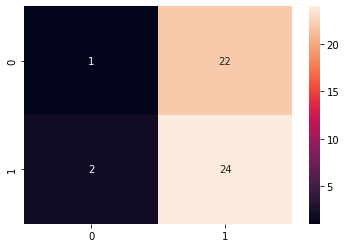

In [30]:
sns.heatmap(cf_matrix, annot=True)

In [31]:
y_prob = clf_svc.predict_proba(x_val)

In [32]:
print(f"Predicción de clase {y_pred_svc[0]} - Paciente con riesgo")
print(f"Probabilidad de pertenencia a la clase {y_prob[0][0]:.2f}")

Predicción de clase 1 - Paciente con riesgo
Probabilidad de pertenencia a la clase 0.65


### Random Forest

Instanciar el clasificador

In [33]:
clf = OneVsRestClassifier(
    RandomForestClassifier(
        n_jobs=-1,
        n_estimators=15000,
        max_depth=22,
        random_state=24,
        criterion='entropy'
    )
)

Entrenar el clasificador

In [34]:
clf.fit(x_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     max_depth=22,
                                                     n_estimators=15000,
                                                     n_jobs=-1,
                                                     random_state=24))

Cálcular la pertenencia de clase para cada uno de los elementos en el conjunto de prueba

In [35]:
y_pred_clf_1 = clf.predict_proba(x_val)
y_pred_df = pd.DataFrame(
    data=y_pred_clf_1,
    columns=[
      'Prob. baja de ataque cardiaco',
      'Prob. alta de ataque cardiaco',
    ]
)

In [36]:
y_pred_df.head(2)

Prob. baja de ataque cardiaco  Prob. alta de ataque cardiaco
0                       0.936733                       0.063267
1                       0.821667                       0.178333

Realizar una predicción sobre todo el conjunto y codificarlo con la etiqueta respectiva

In [37]:
rf_y_pred = (clf.predict(x_val) > 0.5).astype("int32")

Cálcular métricas

In [38]:
# Cálcular métricas
own_metrics(y_true=y_val, y_pred=rf_y_pred)


    Entropía cruzada: 4.93
    Exactitud: 0.86
    Precisión: 0.85
    Recall: 0.88
    F1 Score: 0.87    
  


In [39]:
roc_rf = roc_auc_score(y_val, y_pred_clf_1[:,1], average='macro')
print(f"Área bajo la curva ROC: {roc_rf:.2f}")

Área bajo la curva ROC: 0.93


## Despliegue del modelo

Para realizar el despliegue del modelo vamos a emplear una aproximación mediante contenedores. Para la interfaz de usuario, vamos a emplear una página web de una vista desarrollada con el framework: Django en el cual podremos ingresar desde la vista del navegador un archivo con los datos requeridos de cada una de las variables predictoras.

Si desea ingresar a la interfaz web, por favor no olvide configurar el enrutamiento por proxy a la universidad en su navegador. Para ello, configure los siguientes valores.

- Tipo de proxy: http.
- IP / URL: connect2.virtual.uniandes.edu.co
- Puerto: 443

Posteriormente, haga clic en el siguiente enlace:

[Interfaz Web](http://172.24.99.227:8000)

Dirección a ingresar http://172.24.99.227:8000

## Conclusiones

1. Al generar variables dummies empleando una codificación One Hot Encoding a partir de las variables categoricas los modelos de clasificación quedan con un score de predicción mas alto

2. El modelo de Random Forest es el que nos ha generado un score mas alto, siendo para el ejercicio uno de los modelos con poder de predicción mas alto obteniendo un F-score de 0.88

3. Con base en el F-score podemos ordenar la efectividad de los modelos de la siguiente manera:
- Random Forest: 0.87
- XGBoost: 0.79
- Red neuronal MLP: 0.71
- Máquina de soporte vectorial: 0.69

4. Con respecto a la distribución de los datos, es relevante mencionar nuevamente que, tras observar las distribuciones en los tres subconjuntos para cada una de las caracteristicas de los datos podemos concluir que las tres particiones mantienen la misma distribución.